In [36]:
import casadi as ca
from lib.cartpolesystem import CartPoleStepperMotorSystem
from lib.motors import StepperMotor
from lib.cartpolesystem import Cart, Pole
from lib.cartpoleenv import CartPoleEnv
from lib.numerical import rk4_step
import numpy as np
from numpy import radians
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from lib.controllers import LQR
from time import perf_counter

In [37]:
dt = 0.01
g = 9.81

cart = Cart(0.1, 0.01, (-0.8, 0.8), 0.2)
motor = StepperMotor(0.06, (-10, 10), 0.2, (-2, 2), 0.2)
poles = [Pole(0.1, 0.15, 0.01), Pole(0.2, 0.2, 0.01)]
n = len(poles)

system = CartPoleStepperMotorSystem(cart, motor, poles, g)

max_time = 10
N_env = int(max_time/dt)

env = CartPoleEnv(system, dt, N_env, rk4_step)
env.observation_space.shape

(6,)

In [38]:
n = len(poles)

system = CartPoleStepperMotorSystem(cart, motor, poles, g)

max_time = 10
N_env = int(max_time/dt)

env = CartPoleEnv(system, dt, N_env, rk4_step)
env.observation_space.shape

(6,)

In [39]:
end_time = 5
dt_collocation = 0.03
N_collocation = int(end_time/dt_collocation)+1
h = end_time/N_collocation
# h = dt_collocation

N = int(end_time/dt)

opti = ca.Opti()

xs = opti.variable(N_collocation,system.num_states)
us = opti.variable(N_collocation,system.num_controls)

x0 = np.array([0, 0] + [radians(180), 0]*n)
r = np.array([0, 0] + [0, 0]*n)

In [40]:
opti.subject_to(xs[0,0] == x0[0])
opti.subject_to(xs[-1,0] == r[0])
opti.subject_to(xs[0,1] == x0[1])
opti.subject_to(xs[-1,1] == r[1])

for i in range(system.num_poles*2):
    if i % 2 == 0:
        opti.subject_to(ca.arctan2(ca.sin(x0[i+2]-xs[0,i+2]),ca.cos(x0[i+2]-xs[0,i+2])) == 0)
        opti.subject_to(ca.arctan2(ca.sin(r[i+2]-xs[-1,i+2]),ca.cos(r[i+2]-xs[-1,i+2])) == 0)
    else:
        opti.subject_to(xs[0,i+2] == x0[i+2])
        opti.subject_to(xs[-1,i+2] == r[i+2])
print(opti)

Opti {
  instance #5
  #variables: 1 (nx = 1002)
  #parameters: 0 (np = 0)
  #constraints: 12 (ng = 12)
  CasADi solver needs updating.
}


In [41]:
obj = 0
for i in range(N_collocation-1):
    obj += (us[i,0]**2+us[i+1,0]**2+xs[i,1]**2+xs[i+1,1]**2)*h/2
opti.minimize(obj)
print("Obj:", obj)
# opti.minimize(ca.sumsqr(us))

Obj: (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((0.0299401*(((sq(opti5_x_2[0])+sq(opti5_x_2[1]))+sq(opti5_x_1[167]))+sq(opti5_x_1[168])))/2)+((0.0299401*(((sq(opti5_x_2[1])+sq(opti5_x_2[2]))+sq(opti5_x_1[168]))+sq(opti5_x_1[169])))/2))+((0.0299401*(((sq(opti5_x_2[2])+sq(opti5_x_2[3]))+sq(opti5_x_1[169]))+sq(opti5_x_1[170])))/2))+((0.0299401*(((sq(opti5_x_2[3])+sq(opti5_x_2[4]))+sq(opti5_x_1[170]))+sq(opti5_x_1[171])))/2))+((0.0299401*(((sq(opti5_x_2[4])+sq(opti5_x_2[5]))+sq(opti5_x_1[171]))+sq(opti5_x_1[172])))/2))+((0.0299401*(((sq(opti5_x_2[5])+sq(opti5_x_2[6]))+sq(opti5_x_1[172]))+sq(opti5_x_1[173])))/2))+((0.0299401*(((sq(opti5_x_2[6])+sq(opti5_x_2[7]))+sq(opti5_x_1[173]))+sq(opti5_x_1[174])))/2))+((0.0299401*(((sq(opti5_x_2[7])+sq(opti5_x_2[8]))+sq(opti5_x_1[174]))+sq(opti5_x_1[175])))/2))+((0.0299401*(((sq(opti5_x_2[8])+sq(opti5_x_2[9]))+sq(opti5_x_1[175]))+s

In [42]:
def differentiate(x, u):
    d_s = x[1]
    dd_s = u[0]
    next_x = [i for i in range(system.num_states)]
    next_x[0] = d_s
    next_x[1] = dd_s
    for i in range(system.num_poles):
        theta = x[2+2*i]
        d_theta = x[3+2*i]
        u_p = system.u_ps[i]
        l = system.ls[i]
        m = system.ms[i]
        dd_theta = 3/(7*l/2)*(system.g*ca.sin(theta)-dd_s*ca.cos(theta)-u_p*d_theta/(m*l/2))
        next_x[2+2*i] = d_theta
        next_x[3+2*i] = dd_theta
    return next_x

def constraint_states(state, control):
    d_s = state[1]
    dd_s = control[0]

    sum1 = 0
    sum2 = 0
    sum3 = 0
    sum4 = 0

    for j in range(system.num_poles):
        theta = state[2+2*j]
        d_theta = state[3+2*j]

        l = system.ls[j]
        m = system.ms[j]
        u_p = system.u_ps[j]

        sum1 += m*ca.sin(theta)*ca.cos(theta)
        sum2 += m*l/2*d_theta**2*ca.sin(theta)
        sum3 += u_p*d_theta*ca.cos(theta)/(l/2)
        sum4 += m*ca.cos(theta)**2

    f = 3/7*(system.g*sum1-7/3*(sum2-system.cart.u_c*d_s)-sum3-(sum4-7/3*system.M)*dd_s)
    torque = f*system.motor.r
    
    return np.array([torque])

for i in range(N_collocation):
    s = xs[i,0]
    last_s = xs[i-1,0]
    d_s = xs[i,1]
    last_d_s = xs[i-1,1]
    dd_s = us[i,0]
    last_dd_s = us[i-1,0]
    opti.subject_to(opti.bounded(system.state_lower_bound[0]+system.state_margin[0],s,system.state_upper_bound[0]-system.state_margin[0]))
    opti.subject_to(opti.bounded(system.state_lower_bound[1]+system.state_margin[1],d_s,system.state_upper_bound[1]-system.state_margin[1]))

    d_x = differentiate(xs[i,:],us[i,:])
    last_d_x = differentiate(xs[i-1,:],us[i-1,:])

    if i > 0:
        opti.subject_to((d_s+last_d_s)*h/2 == (s-last_s)) 
        opti.subject_to((dd_s+last_dd_s)*h/2 == (d_s-last_d_s)) 

        for j in range(system.num_poles):
            theta = xs[i,2+2*j]
            last_theta = xs[i-1,2+2*j]
            d_theta = xs[i,3+2*j]
            last_d_theta = xs[i-1,3+2*j]
            
            dd_theta = d_x[3+2*j]
            last_dd_theta = last_d_x[3+2*j]

            opti.subject_to((d_theta+last_d_theta)*h/2 == (theta-last_theta))
            opti.subject_to((dd_theta+last_dd_theta)*h/2 == (d_theta-last_d_theta))
    
    constraint_state = constraint_states(xs[i,:],us[i,:])
    f = constraint_state[0]
    torque = f*system.motor.r
    opti.subject_to(opti.bounded(system.motor.torque_bounds[0]*(1-system.motor.torque_margin),torque,system.motor.torque_bounds[1]*(1-system.motor.torque_margin)))
    first = False
        

In [43]:
x_guess = np.linspace(x0, r, N_collocation)
u_guess = np.zeros((N_collocation, system.num_controls))

opti.set_initial(xs, x_guess)
opti.set_initial(us, u_guess)
opti

Opti(Opti {
  instance #5
  #variables: 2 (nx = 1169)
  #parameters: 0 (np = 0)
  #constraints: 1509 (ng = 1509)
  CasADi solver needs updating.
})

In [44]:
start_time = perf_counter()
opti.solver("ipopt")
sol = opti.solve()
end_time = perf_counter()
print(f"Time to solve: {end_time-start_time} s")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     4660
Number of nonzeros in inequality constraint Jacobian.:     1336
Number of nonzeros in Lagrangian Hessian.............:     1670

Total number of variables............................:     1169
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1008
Total number of inequality c

In [45]:
x_optimal_raw = sol.value(xs)
u_optimal_raw = sol.value(us)

time_collocation = np.linspace(0, end_time, N_collocation)

In [46]:
time = np.linspace(0, end_time, N)

states = np.vstack([
    CubicSpline(time_collocation, s_row)(time) for s_row in x_optimal_raw.T
]).T
controls = np.vstack(np.interp(time, time_collocation, u_optimal_raw))

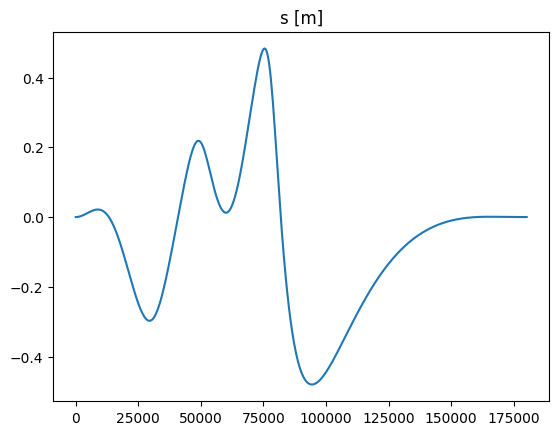

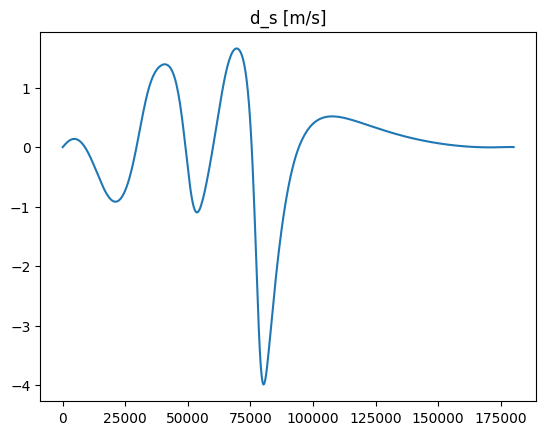

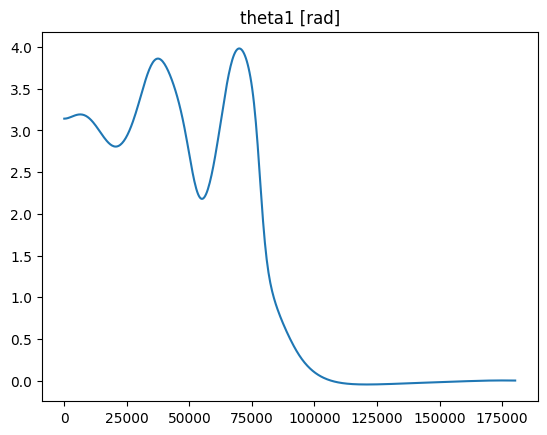

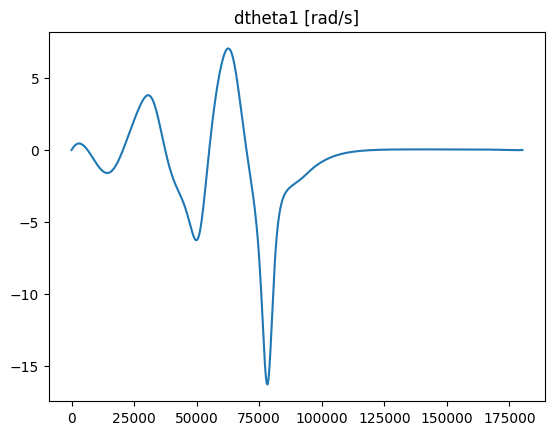

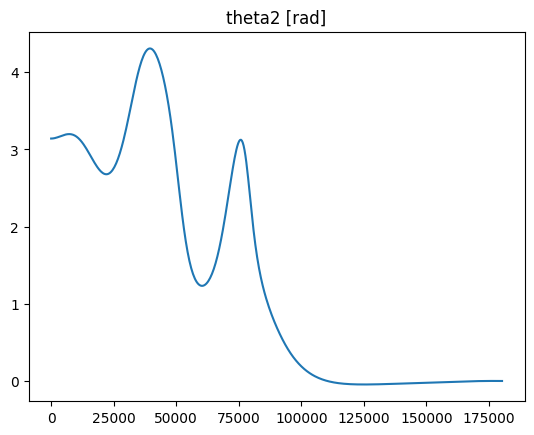

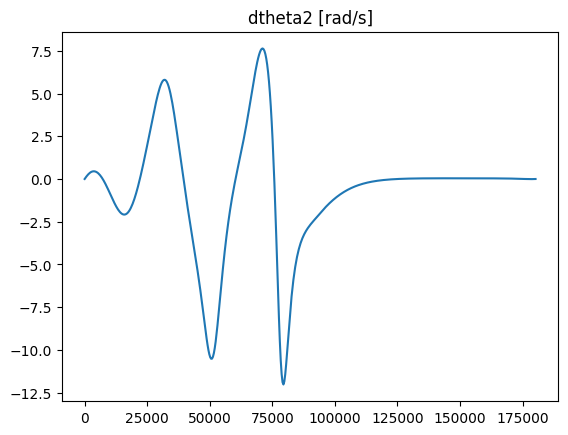

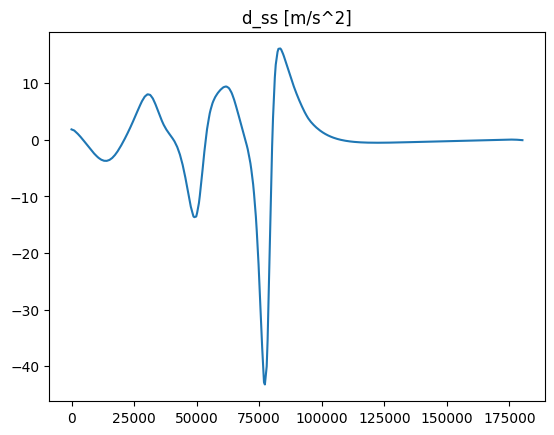

In [47]:
labels = ["s [m]", "d_s [m/s]", "theta1 [rad]", "dtheta1 [rad/s]", "theta2 [rad]", "dtheta2 [rad/s]", "theta3 [rad]", "dtheta3 [rad/s]", "theta4 [rad]", "dtheta4 [rad/s]"]

for i in range(system.num_states):
    plt.figure()
    plt.title(labels[i])
    plt.plot(time, states[:,i])
    plt.show()

plt.title("d_ss [m/s^2]")
plt.plot(time, controls)
plt.show()

In [54]:
np.set_printoptions(precision=2)

linearization_x0 = np.zeros(2+2*n)
linearization_u0 = np.array([0])

A0, B0 = system.linearize(linearization_x0, linearization_u0)

C = np.diag([1, 1]+[1, 1]*n)

D = np.zeros((1, 1))

ct_dt = dt

lqr = LQR(ct_dt)

Q = np.diag([100, 10]+[100, 10]*n)
R = np.diag([1])

A_d0, B_d0 = lqr.discretize(A0, B0, C, D)
K_d0 = lqr.calculate_K_d(A_d0, B_d0, Q, R)

print("A:", A0)
print("B:", B0)

A: [[ 0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.   56.06 -7.62  0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    0.    0.   42.04 -2.14]]
B: [[ 0.  ]
 [ 1.  ]
 [ 0.  ]
 [-5.71]
 [ 0.  ]
 [-4.29]]


In [55]:
print("Calculating As and Bs...")
As, Bs = np.vectorize(system.linearize, signature='(n),(m)->(n,n),(n,m)')(states, controls)

Calculating As and Bs...


In [56]:
print("Calculating A_ds and B_ds...")
A_ds, B_ds = np.vectorize(lqr.discretize, signature='(n,n),(n,m),(a,b),(c,d)->(n,n),(n,m)')(As, Bs, C, D)
print("Calculating K_ds...")
_, K_ds = lqr.calculate_finite_K_ds(A_ds, B_ds, Q, R)

Calculating A_ds and B_ds...
Calculating K_ds...


In [57]:
print("Memory usage K_ds: ", (K_ds.nbytes)/1024**1, "KB")

Memory usage K_ds:  23.4375 KB


In [58]:
last_update = perf_counter()

state, _ = env.reset(x0)
late_r = np.array([0.7, 0] + [0, 0]*n)

errors = np.zeros((N_env, 2+2*n))
feedback_controls = np.zeros((N_env, 1))

for i in range(N_env-1):
    while perf_counter() < last_update + dt:
        pass
    last_update = perf_counter()

    error = np.zeros(2+2*n)
    if i < N*1:
        error = system.calculate_error(state, states[i])
        u_ff = controls[i]
        u_fb = lqr.feedback(K_ds[i], error)
        u = u_ff + u_fb
        feedback_controls[i] = u_fb
    else:
        error = system.calculate_error(state, late_r)
        u = lqr.feedback(K_ds[-1], error)
    errors[i] = error

    state, reward, done, msg, _ = env.step(u)
    env.render()

env.close()

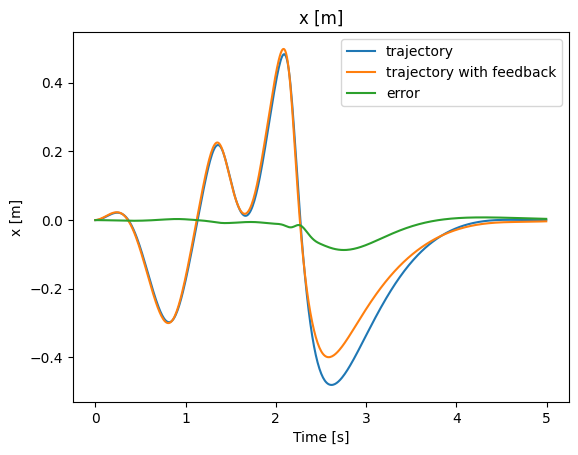

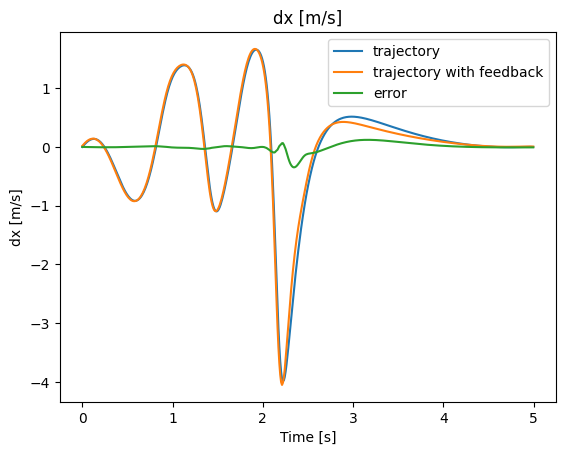

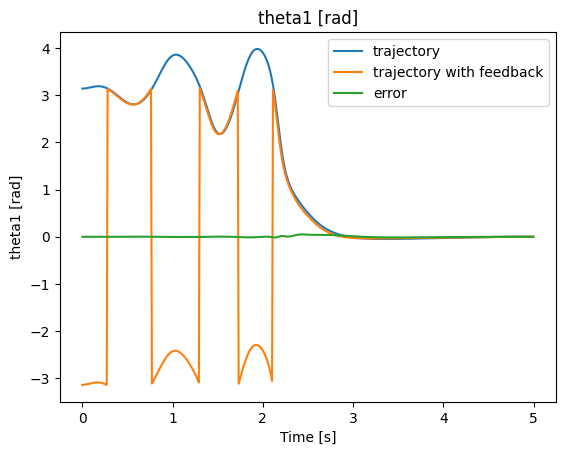

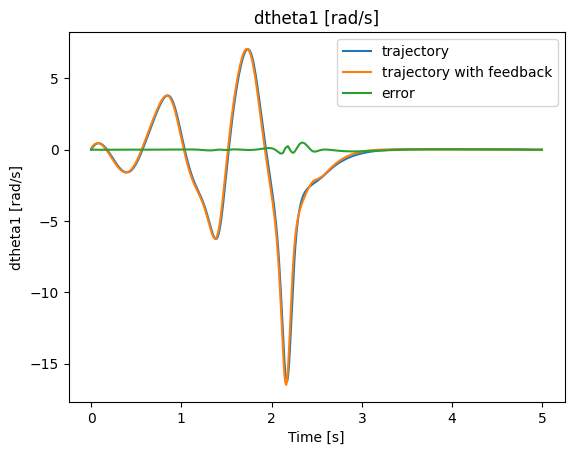

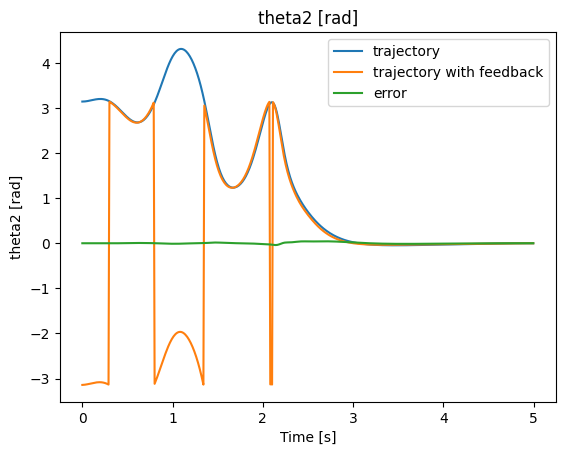

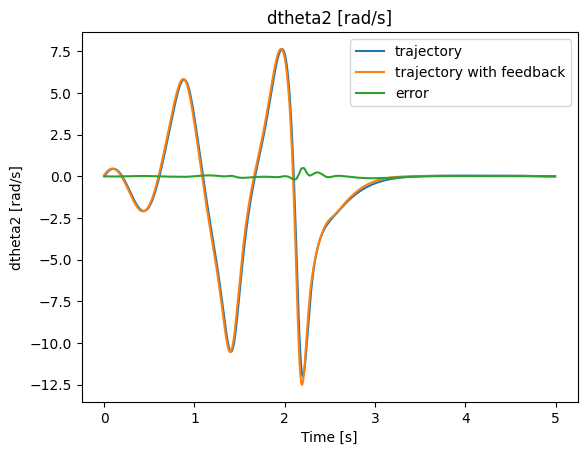

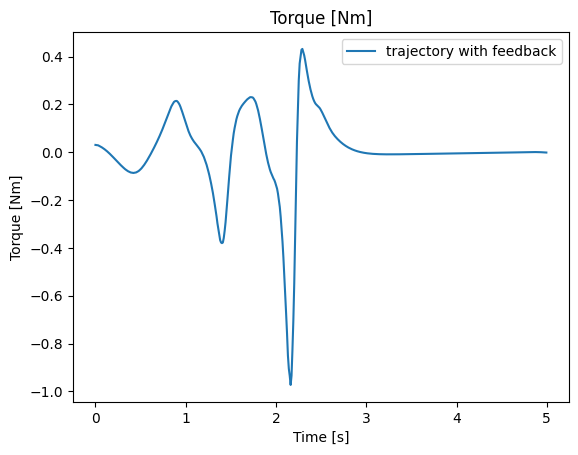

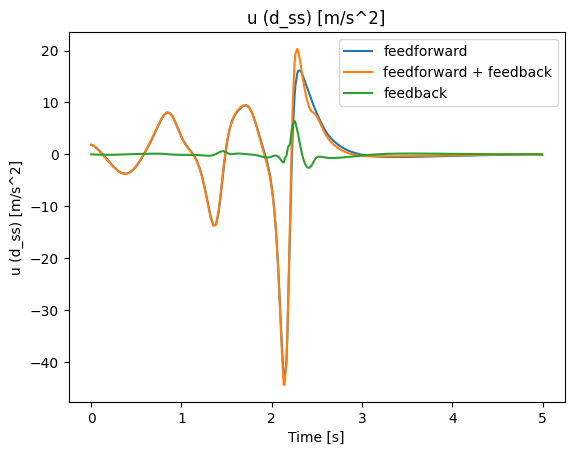

In [59]:
time = np.linspace(0, max_time, N_env)
state_labels = ["x [m]", "dx [m/s]", "theta1 [rad]", "dtheta1 [rad/s]", "theta2 [rad]", "dtheta2 [rad/s]", "theta3 [rad]", "dtheta3 [rad/s"]
for i in range(system.num_states):
    plt.xlabel("Time [s]")
    plt.ylabel(state_labels[i])
    plt.title(state_labels[i])
    plt.plot(time[:N], states.T[i][:N], label="trajectory")
    plt.plot(time[:N], env.states.T[i][1:N+1], label="trajectory with feedback")
    plt.plot(time[:N], errors.T[i][:N], label="error")
    plt.legend()
    plt.show()

constrain_labels = ["Torque [Nm]"]
for i in range(system.num_constraint_states):
    plt.xlabel("Time [s]")
    plt.ylabel(constrain_labels[i])
    plt.title(constrain_labels[i])
    plt.plot(time[:N], env.constraint_states.T[i][1:N+1], label="trajectory with feedback")
    plt.legend()
    plt.show()

plt.title("u (d_ss) [m/s^2]")
plt.xlabel("Time [s]")
plt.ylabel("u (d_ss) [m/s^2]")
plt.plot(time[:N], controls.T[0][:N], label="feedforward")
plt.plot(time[:N], env.controls.T[0][1:N+1], label="feedforward + feedback")
plt.plot(time[:N], feedback_controls.T[0][:N], label="feedback")
plt.legend()
plt.show()